# Import

In [ ]:
import numpy as np 
import pandas as pd 
import imageio
import matplotlib.pyplot as plt
import math
from scipy import ndimage 
import numpy as np
from skimage import filters
import os
import tensorflow as tf
import random
from PIL import Image 
from keras.optimizers import Adam, RMSprop
import random

# **Path Creator**

Salva in X_paths i paths delle immagini di training, in Y_paths i path delle depth map e in val_mask_paths i path delle validity mask delle immagini.

Da usare soltanto senza crop

In [ ]:
path = '../input/diode-indoor/indoors/'

X_paths = []
Y_paths = []
val_mask_paths = []

for scene_num in os.listdir(path):
    #Per un addestrammento rapido l'if preleva le immagini da una sola scena
    #if (scene_num != "scene_00001" and scene_num != "scene_00002" and scene_num != "scene_00003" and scene_num != "scene_00004" and scene_num != "scene_00005" and scene_num != "scene_00006" ):
    for scan_dir in os.listdir(path + '/'+ scene_num):
        for r, d, f in os.walk(path + '/'+ scene_num + '/' + scan_dir):
            for file in f:
                if file.endswith(".png"):
                    X_paths.append(os.path.join(r, file))
                elif file.endswith("depth.npy"):
                    Y_paths.append(os.path.join(r, file))
                elif file.endswith("depth_mask.npy"):
                    val_mask_paths.append(os.path.join(r, file))
X_paths.sort()
Y_paths.sort()
val_mask_paths.sort()

indexes = np.arange(len(X_paths))
np.random.shuffle(indexes)
X_paths_shuffle = [X_paths[k] for k in indexes]
Y_paths_shuffle = [Y_paths[k] for k in indexes]
val_mask_paths_shuffle = [val_mask_paths[k] for k in indexes]

print(X_paths_shuffle[0])
print(Y_paths_shuffle[0])
print(val_mask_paths_shuffle[0])

# **Path Creator for Crops**

Per la lettura dei crop

In [ ]:

X_paths = []
Y_paths = []
val_mask_paths = []

path_crop = '../input/diodeindoorcrop/diode-indoor-crop/'

for scene_num in os.listdir(path_crop):
    (scene_num != "scene_00001" and scene_num != "scene_00002" and scene_num != "scene_00003" and scene_num != "scene_00004" and scene_num != "scene_00005" and scene_num != "scene_00006" ):
        for r, d, f in os.walk(path_crop + scene_num):
            for file in f:
                if file.endswith(".png"):
                    X_paths.append(os.path.join(r, file))
                elif file.endswith("depth_crop1.npy") or file.endswith("depth_crop2.npy") or file.endswith("depth_crop3.npy") or file.endswith("depth_crop4.npy"):
                    Y_paths.append(os.path.join(r, file))
                elif file.endswith("depth_mask_crop1.npy") or file.endswith("depth_mask_crop2.npy") or file.endswith("depth_mask_crop3.npy") or file.endswith("depth_mask_crop4.npy"):
                    val_mask_paths.append(os.path.join(r, file))
                
X_paths.sort()
Y_paths.sort()
val_mask_paths.sort()

indexes = np.arange(len(X_paths))
np.random.shuffle(indexes)
X_paths_shuffle = [X_paths[k] for k in indexes]
Y_paths_shuffle = [Y_paths[k] for k in indexes]
val_mask_paths_shuffle = [val_mask_paths[k] for k in indexes]

# **Path Creator for Resize**

Per la lettura delle immagini con resize

In [ ]:

X_paths = []
Y_paths = []
val_mask_paths = []

path_resize = '../input/diodeindoorresize/diode-indoor-resize/'

for scene_num in os.listdir(path_resize):
    for r, d, f in os.walk(path_resize + '/'+ scene_num):
        for file in f:
            if file.endswith(".png"):
                X_paths.append(os.path.join(r, file))
            elif file.endswith("depth_resize.npy"):
                Y_paths.append(os.path.join(r, file))
            elif file.endswith("depth_mask_resize.npy"):
                val_mask_paths.append(os.path.join(r, file))
X_paths.sort()
Y_paths.sort()
val_mask_paths.sort()

indexes = np.arange(len(X_paths))
np.random.shuffle(indexes)
X_paths_shuffle = [X_paths[k] for k in indexes]
Y_paths_shuffle = [Y_paths[k] for k in indexes]
val_mask_paths_shuffle = [val_mask_paths[k] for k in indexes]

# **Path Creator for Crop and Resize**

Per la lettura delle immagini con crop e resize

In [ ]:
X_paths = []
Y_paths = []
val_mask_paths = []

path_crop_resize = '../input/diode-indoor-conditioned-crop-and-resize/diode-indoor-condition_crop/'

for scene_num in os.listdir(path_crop_resize):
    for r, d, f in os.walk(path_crop_resize + scene_num):
        for file in f:
            if file.endswith(".png"):
                X_paths.append(os.path.join(r, file))
            elif file.endswith("depth_crop1.npy") or file.endswith("depth_crop2.npy") or file.endswith("depth_crop3.npy") or file.endswith("depth_crop4.npy") or file.endswith("depth_resize.npy"):
                Y_paths.append(os.path.join(r, file))
            elif file.endswith("depth_mask_crop1.npy") or file.endswith("depth_mask_crop2.npy") or file.endswith("depth_mask_crop3.npy") or file.endswith("depth_mask_crop4.npy") or file.endswith("depth_mask_resize.npy"):
                val_mask_paths.append(os.path.join(r, file))
                
X_paths.sort()
Y_paths.sort()
val_mask_paths.sort()

indexes = np.arange(len(X_paths))
np.random.shuffle(indexes)
X_paths_shuffle = [X_paths[k] for k in indexes]
Y_paths_shuffle = [Y_paths[k] for k in indexes]
val_mask_paths_shuffle = [val_mask_paths[k] for k in indexes]

# **Split Training, Validation and Test set**

Definizione del numero di campioni per training set, validation set e test set.
Train: 0.8 * 0.8 = 0.64, val: 0.8 * 0.2 = 0.16, test: 0.2


In [ ]:
TRAIN_RATIO = 0.8 
print("Dimensione dataset:",len(X_paths))
n_train_examples = int(len(X_paths) * TRAIN_RATIO)
n_test_examples = len(X_paths) - n_train_examples

old_n_train_examples = n_train_examples
n_train_examples = int(n_train_examples * TRAIN_RATIO)
n_validation_examples = old_n_train_examples - n_train_examples

print("Dimensione training set:",n_train_examples, "\nDimensione: validation set:",n_validation_examples, "\nDimensione: test set:",n_test_examples)

Definizione iperparametri

In [ ]:
epochs = 10
examples = len(X_paths)
batch_size = 2
batch = examples/batch_size

# **Generator con Data augmentation**

Si crea una classe Generatore figlia della classe Sequence, affinché si alleggerisca il carico della RAM. Si effettua l'override delle funzioni __init__, __len__, __getitem__, __on_epoch_end__.

In [ ]:
from PIL import Image
random.seed(0)

class BasicPolicy(object):
    def __init__(self, mirror_ratio = 0, flip_ratio = 0, color_change_ratio = 0, is_full_set_colors = False, add_noise_peak = 0.0, erase_ratio = -1.0):
        # Random color channel order
        from itertools import product, permutations
        self.indices = list(product([0,1,2], repeat = 3)) if is_full_set_colors else list(permutations(range(3), 3))
        self.indices.insert(0, [0,1,2]) # R,G,B
        self.add_noise_peak = add_noise_peak

        # Mirror and flip
        self.color_change_ratio = color_change_ratio
        self.mirror_ratio = mirror_ratio
      #  self.flip_ratio = flip_ratio

        # Erase
        self.erase_ratio = erase_ratio

    def __call__(self, img, depth, val_mask):

        # 0) Add poisson noise (e.g. choose peak value 20)
        if self.add_noise_peak > 0:
            PEAK = self.add_noise_peak
            #img = np.random.poisson(np.clip(img, 0, 1) * PEAK) / PEAK
            img = np.random.poisson(img * PEAK) / PEAK

        # 1) Color change
        policy_idx = random.randint(0, len(self.indices) - 1)
        if random.uniform(0, 1) >= self.color_change_ratio:
            policy_idx = 0

        img = img[...,list(self.indices[policy_idx])]

        # 2) Mirror image
        if random.uniform(0, 1) <= self.mirror_ratio:
            img = img[:,::-1,:]
            depth = depth[:,::-1,:]
            val_mask = val_mask[:,::-1]
            #img = ImageOps.mirror(img)
       
        return img, depth, val_mask

In [ ]:
from tensorflow.keras.utils import Sequence
from imageio import imread

class Generatore(Sequence):

    def __init__(self, x_set, y_set, val_set, batch_size = 10, shuffle = True, is_color_change=False, is_mirror=False, is_flip=False, is_addnoise=False, is_erase=False):
        self.x, self.y = x_set, y_set
        self.mask = val_set
        self.policy = BasicPolicy(color_change_ratio=0.0 if not is_color_change else 0.50, mirror_ratio=0.0 if not is_mirror else 0.50, 
                                  flip_ratio=0.0 if not is_flip else 0.2, 
                                  add_noise_peak=0 if not is_addnoise else 1.2, erase_ratio=-1.0 if not is_erase else 0.5)
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.x)/self.batch_size))

    def __getitem__(self, idx, is_apply_policy=True):
        
        batch_x = []
        batch_y = []
        batch_val = []
        
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x_path = [self.x[k] for k in indexes]
        batch_y_path = [self.y[k] for k in indexes]
        batch_val_path = [self.mask[k] for k in indexes]
        
        
        if is_apply_policy: 
            for i in range(len(batch_x_path)):
                
                x = []
                y = []
                val = []
                
                x, y, val = self.policy(imread(batch_x_path[i]), np.load(batch_y_path[i]), np.load(batch_val_path[i]))
                
                #temp = np.zeros((768, 1024, 2))
                temp = np.zeros((384, 512, 2))
                temp[:,:,0] = y.reshape(y.shape[0], y.shape[1])
                temp[:,:,1] = val
                
                batch_x.append(x)
                batch_y.append(temp)
            
        return np.array(batch_x).astype('float32')/255, np.array(batch_y)
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# **Generator senza Data augmentation**


In [ ]:
from tensorflow.keras.utils import Sequence
from imageio import imread

class Generatore(Sequence):

    def __init__(self, x_set, y_set, val_set, batch_size = 10, shuffle = True):
        self.x, self.y = x_set, y_set
        self.mask = val_set
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.x)/self.batch_size))

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x = [self.x[k] for k in indexes]
        batch_y = [self.y[k] for k in indexes]
        batch_val = [self.mask[k] for k in indexes]
        return np.array([imread(file_name_x) for file_name_x in batch_x]).astype('float32')/255, np.array([np.load(file_name_y) for file_name_y in batch_y]) * np.expand_dims(np.array([np.load(file_name_val) for file_name_val in batch_val]), -1) 
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
# Prepare the training dataset.
#train_dataset = Generatore(X_paths[:n_train_examples], Y_paths[:n_train_examples], val_mask_paths[:n_train_examples], batch_size = batch_size)
#validation_dataset = Generatore(X_paths[n_train_examples:n_train_examples + n_validation_examples], Y_paths[n_train_examples:n_train_examples + n_validation_examples], val_mask_paths[n_train_examples:n_train_examples + n_validation_examples], batch_size = batch_size)
#test_dataset = Generatore(X_paths[n_train_examples + n_validation_examples:], Y_paths[n_train_examples + n_validation_examples:], val_mask_paths[n_train_examples + n_validation_examples:],batch_size = batch_size, shuffle = False)

#train_dataset = Generatore(X_paths_shuffle[:n_train_examples], Y_paths_shuffle[:n_train_examples], val_mask_paths_shuffle[:n_train_examples], batch_size = batch_size)
#validation_dataset = Generatore(X_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], Y_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], val_mask_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], batch_size = batch_size)
#test_dataset = Generatore(X_paths_shuffle[n_train_examples + n_validation_examples:], Y_paths_shuffle[n_train_examples + n_validation_examples:], val_mask_paths_shuffle[n_train_examples + n_validation_examples:],batch_size = batch_size, shuffle = False)

#Per data augmentation
train_dataset = Generatore(X_paths_shuffle[:n_train_examples], Y_paths_shuffle[:n_train_examples], val_mask_paths_shuffle[:n_train_examples], batch_size = batch_size, is_color_change=False, is_mirror=True, is_flip=False, is_addnoise=False)
validation_dataset = Generatore(X_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], Y_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], val_mask_paths_shuffle[n_train_examples:n_train_examples + n_validation_examples], batch_size = batch_size, is_color_change=False, is_mirror=False, is_flip=False, is_addnoise=False)
test_dataset = Generatore(X_paths_shuffle[n_train_examples + n_validation_examples:], Y_paths_shuffle[n_train_examples + n_validation_examples:], val_mask_paths_shuffle[n_train_examples + n_validation_examples:],batch_size = batch_size, shuffle = False, is_color_change=False, is_mirror=False, is_flip=False, is_addnoise=False)

In [ ]:
a, b = train_dataset[0]
print(b.shape)
print(a.shape)

plt.figure(figsize=(8,6), dpi = 100)
plt.subplot(1,2,1), plt.imshow(a[5,:,:,:])
plt.subplot(1,2,2), plt.imshow(a[8,:,:,:])
plt.figure(figsize=(8,6), dpi = 100)
plt.subplot(1,2,1), plt.imshow(b[5,:,:,0], vmin = 0, vmax = 5)
plt.subplot(1,2,2), plt.imshow(b[8,:,:,0], vmin = 0, vmax = 5)
plt.figure(figsize=(8,6), dpi = 100)
plt.subplot(1,2,1), plt.imshow(b[5,:,:,1], vmin = 0, vmax = 1, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(b[8,:,:,1], vmin = 0, vmax = 1, cmap = 'gray')

print(b[5,:,:,1])
print(b[8,:,:,1])

# **Modello con DenseNet121**

Densely Connected Convolutional Networks. DenseNets have several compelling advantages: they alleviate the **vanishing-gradient** problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.

DenseNets do not sum the output feature
 maps of the layer with the incoming feature maps but concatenate them.

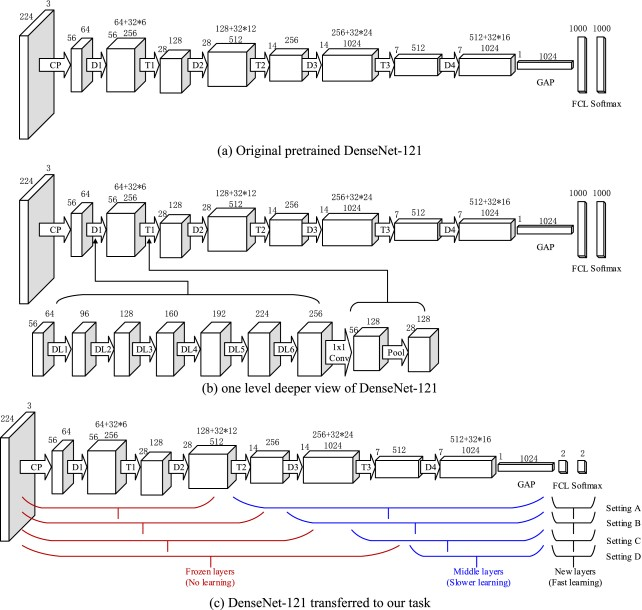
Nel ***Dense Block*** ogni strato accetta tutte le mappe di caratteristiche precedenti come input.


Hl(·) è una funzione composta di tre operazioni consecutive: 
-	normalizzazione batch (BN), 
-	ReLU
-	una convoluzione 3 × 3 (Conv).

I livelli tra i blocchi sono detti ***transition layer*** che eseguono la convoluzione e pooling

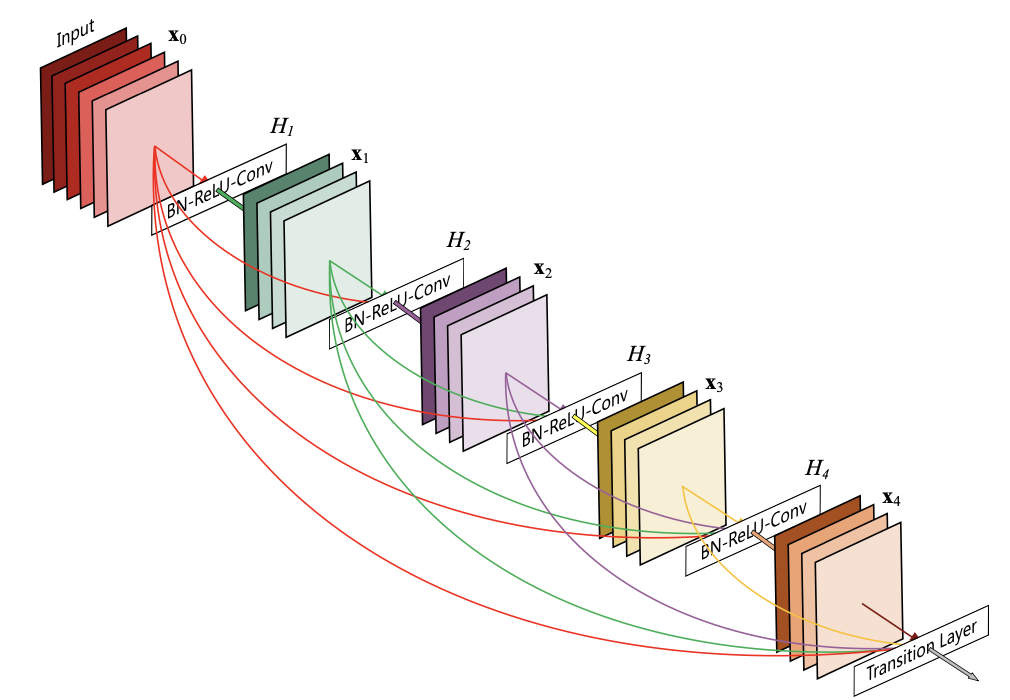

In [ ]:
from keras import applications
from keras.models import Model, load_model
from keras.layers import Input, InputLayer, Conv2D, Activation, LeakyReLU, Concatenate, UpSampling2D

'''ENCODER'''

base_model = applications.DenseNet121(weights="imagenet", input_shape=(384, 512, 3), include_top=False) #loads weights pre-trained on ImageNet

# Freezing Layer
for layer in base_model.layers: layer.trainable = False

'''DECODER'''
# Starting point for decoder
base_model_output_shape = base_model.layers[-1].output.shape 

# Starting number of decoder filters
#decode_filters = int(int(base_model_output_shape[-1])/2)
decode_filters = int(base_model_output_shape[-1])

# Define upsampling layer
def upproject(tensor, filters, name, concat_with):
    #up_i =BilinearUpSampling2D((2, 2), name=name+'_upsampling2d')(tensor)
    
    up_i = UpSampling2D(size=(2, 2), interpolation='bilinear')(tensor)
    up_i = Concatenate(name=name+'_concat')([up_i, base_model.get_layer(concat_with).output]) # Skip connection
    up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')(up_i)
    up_i = LeakyReLU(alpha=0.2)(up_i)
    
    '''da decommentare se la rete regge "fa solo bene.-cit"'''
    #up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')(up_i)
    #up_i = LeakyReLU(alpha=0.2)(up_i)
    #up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convC')(up_i)
    #up_i = LeakyReLU(alpha=0.2)(up_i)
    return up_i

# Decoder Layers
decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=base_model_output_shape, name='conv2')(base_model.output)

decoder = upproject(decoder, int(decode_filters/2), 'up1', concat_with='pool3_pool')
decoder = upproject(decoder, int(decode_filters/4), 'up2', concat_with='pool2_pool')
decoder = upproject(decoder, int(decode_filters/8), 'up3', concat_with='pool1')
decoder = upproject(decoder, int(decode_filters/16), 'up4', concat_with='conv1/relu')
#if False: decoder = upproject(decoder, int(decode_filters/32), 'up5', concat_with='input_1')
decoder = upproject(decoder, int(decode_filters/32), 'up5', concat_with=base_model.layers[0].name)

# Extract depths (FINAL LAYER)
#up5 = UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder) 
conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')(decoder)

'''MODEL'''
model = Model(inputs=base_model.input, outputs=conv3)
#model.summary()

# **Modello U-Net tensorflow**

In [ ]:
'''#base_model = tf.keras.applications.MobileNetV2(input_shape=[384, 512, 3], include_top=False)
#base_model = tf.keras.applications.MobileNetV2(input_shape=[768, 1024, 3], include_top=False)
#base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(384, 512, 3))
#base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(768, 1024, 3))
base_model = tf.keras.applications.DenseNet121(input_shape=(384, 512, 3), include_top=False)
#base_model = tf.keras.applications.DenseNet121(input_shape=(768, 1024, 3), include_top=False)

'''
'''# Use the activations of these layers
#Layers MobilenetV2
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'
]'''
'''

'''
'''#Layers Resnet50
layer_names = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_3_conv'
]'''
'''

#Layers Densenet121
layer_names = [
    'conv1/relu',
    'pool2_relu',
    'pool3_relu',
    'pool4_relu',
    'conv5_block16_2_conv'
]


base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

#base_model.summary()

#Definizione di pix2pix per tensorflow v2
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

"""Layer per l'upsampling"""
up_stack = [
    #upsample(1024, 3),
    upsample(512, 3),
    upsample(256, 3),
    upsample(128, 3),
    upsample(64, 3)
]

Definizione decoder
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[384, 512, 3])
    #inputs = tf.keras.layers.Input(shape=[768, 1024, 3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same') 

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(1)
model.summary()'''

# **Loss**

In [ ]:
import keras.backend as K
def L1_loss(y_true,y_pred): return K.mean(K.abs(y_true-y_pred)) 

def L2_loss(y_true,y_pred): return K.mean(K.square(y_true-y_pred))

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=100.0):
    gt = y_true[:,:,:,0]
    valid_mask = y_true[:,:,:,1]
    gt = tf.expand_dims(gt, -1)
    valid_mask = tf.expand_dims(valid_mask, -1)

    pred_eval = y_pred * valid_mask
    gt_eval = gt * valid_mask
        
    # Point-wise depth
    l_depth = K.mean(K.abs(pred_eval - gt_eval), axis=-1)
    
    #Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    #Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(gt_eval, pred_eval, maxDepthVal)) * 0.5, 0, 1)

    #Weights
    w_ssim = 1
    w_edge = 1
    w_l1 = theta

    return (w_ssim * l_ssim) + (w_edge * K.mean(l_edges)) + (w_l1 * K.mean(l_depth))
    #return L1_loss(gt_eval, pred_eval)
    #return L2_loss(gt_eval, pred_eval)

# **Learning Rate Decay**

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    #decay_steps= (epochs * examples)//batch,  
    decay_steps= 3 * batch,
    decay_rate=0.9)
#optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

# **EVALUATE**

Calcola le metriche di funzionamento del modello,
i **δ** sono gli errori massimi relativi ammessi oltre il quale una predizione (pred) non è da considerarsi corretta, considerando come massima soglia di errore tollerata rispettivamente il **125% (δ1 < 12.5), il 156% (δ < 12.5^2) ed il 195% (δ < 12.5^3)** nel calcolo della distanza tra il valore della profondità nella predizione e quello nella ground truth (gt) o viceversa (con la funzione maximum poniamo al numeratore sempre il valore della profondità più grande tra pred e gt in modo da calcolarci la loro distanza in maniera proporzionale tra loro)

In [ ]:
def compute_errors(pred, gt):
    
    #validity_mask = gt > 0
    validity_mask = gt[:,:,:,1]
    validity_mask = np.expand_dims(validity_mask, -1)
    validity_mask = np.array(validity_mask, dtype=bool)
    
    gt = np.expand_dims(gt, -1)
    
    pred_eval = np.ma.masked_where(~validity_mask, pred)
    gt_eval = np.ma.masked_where(~validity_mask, gt[:,:,:,0])
    
    threshold = np.maximum((gt_eval / pred_eval), (pred_eval / gt_eval))

    delta1 = (threshold < 1.25).mean()
    delta2 = (threshold < 1.25 ** 2).mean()
    delta3 = (threshold < 1.25 ** 3).mean()

    abs_diff = np.abs(pred_eval - gt_eval)

    mae = np.mean(abs_diff)
    rmse = np.sqrt(np.mean(np.power(abs_diff, 2)))
    abs_rel = np.mean(abs_diff / gt_eval)

    log_abs_diff = np.abs(np.log10(pred_eval) - np.log10(gt_eval))

    log_mae = np.mean(log_abs_diff)
    log_rmse = np.sqrt(np.mean(np.power(log_abs_diff, 2)))

    return mae, rmse, abs_rel, log_mae, log_rmse, delta1, delta2, delta3


def evaluate(model, test_dataset, batch_size=batch_size, verbose=False):
    index = 0
    
    batch_mae = []
    batch_rmse = []
    batch_abs_rel = []
    batch_log_mae = []
    batch_log_rmse = []
    batch_delta1 = []
    batch_delta2 = []
    batch_delta3 = []
    
    for i in range(len(test_dataset)):
        rgb, depth = test_dataset[i]
    
        predictions = np.stack(outputs[ index : index + len(depth) ], axis=0)
        testSetDepths = np.stack(depth, axis=0)
        
        e = compute_errors(predictions, testSetDepths)
        batch_mae.append(e[0])
        batch_rmse.append(e[1])
        batch_abs_rel.append(e[2])
        batch_log_mae.append(e[3])
        batch_log_rmse.append(e[4])
        batch_delta1.append(e[5])
        batch_delta2.append(e[6])
        batch_delta3.append(e[7])
        
        index = index + len(depth)
        
    mae = np.mean(batch_mae)
    rmse = np.mean(batch_rmse)
    abs_rel = np.mean(batch_abs_rel)
    log_mae = np.mean(batch_log_mae)
    log_rmse = np.mean(batch_log_rmse)
    delta1 = np.mean(batch_delta1)
    delta2 = np.mean(batch_delta2)
    delta3 = np.mean(batch_delta3)

    return mae, rmse, abs_rel, log_mae, log_rmse, delta1, delta2, delta3

# **Random Search**

In [ ]:
max_count = 3
for count in range(max_count):
    lr = 10**random.uniform(-3, -2)
    
    print()
    print('iteration:' + str(count))
    print('lr:' + str(lr))
    
    optimizer = Adam(lr, amsgrad=True)
    
    model.compile(loss=depth_loss_function, optimizer=optimizer)
    model.save_weights('/kaggle/working/model.h5')
    
    model_info = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=0)
    
    val_loss = model_info.history['val_loss']
    train_loss = model_info.history['loss']

    t = np.arange(len(val_loss)) + 1

    plt.figure()
    plt.plot(t,train_loss)
    plt.plot(t,val_loss)
    plt.legend(['train loss', 'val loss'])

    outputs = model.predict(validation_dataset)
    
    np.seterr(divide='ignore', invalid='ignore')

    evaluation_metrics = evaluate(model, validation_dataset, batch_size=batch_size)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('mae', 'rmse', 'abs_rel', 'log_mae', 'log_rmse', 'delta1', 'delta2', 'delta3'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(evaluation_metrics[0],evaluation_metrics[1],evaluation_metrics[2],evaluation_metrics[3],evaluation_metrics[4],evaluation_metrics[5],evaluation_metrics[6],evaluation_metrics[7]))
    
    model.load_weights('/kaggle/working/model.h5')

# **Fit**

In [ ]:

optimizer = Adam(0.0001, amsgrad=True)
model.compile(loss=depth_loss_function, optimizer=optimizer)

model_info = model.fit(train_dataset, validation_data = validation_dataset, epochs = epochs, verbose = 1)

val_loss = model_info.history['val_loss']
train_loss = model_info.history['loss']

t = np.arange(len(val_loss)) + 1

plt.figure()
plt.plot(t,train_loss)
plt.plot(t,val_loss)
plt.legend(['train loss', 'val loss'])

# **Prediction**

Predizione di una sola immagine di test.

In [ ]:
'''
a, b = train_dataset[1]

var_copia_x = np.copy(a[2,:,:,:])
var_copia_y = np.copy(b[2,:,:,:])

var_copia_x = var_copia_x.reshape(1,var_copia_x.shape[0],var_copia_x.shape[1],var_copia_x.shape[2])
print(var_copia_x.shape)
var_copia_y = var_copia_y.reshape(1,var_copia_y.shape[0],var_copia_y.shape[1],var_copia_y.shape[2])
print(var_copia_y.shape)
'''

# **Funzione di DIODE per visualizzare le depth map con punti neri sui pixel non validi**

In [ ]:
'''def plot_depth_map(dm, gt):
    validity_mask = gt > 0
    MIN_DEPTH = 0.5     
    MAX_DEPTH = min(50, np.percentile(dm, 99))     
    dm = np.clip(dm, MIN_DEPTH, MAX_DEPTH)
    gt = np.clip(gt, MIN_DEPTH, MAX_DEPTH)
    dm = np.log(dm, where=validity_mask)
    gt = np.log(gt, where=validity_mask)
    dm = np.ma.masked_where(~validity_mask, dm)
    gt = np.ma.masked_where(~validity_mask, gt)    
    cmap = plt.cm.jet     
    cmap.set_bad(color='black')   
    plt.figure(figsize=(8,6), dpi = 150)
    plt.subplot(1,2,1), plt.imshow(dm, cmap=cmap, vmax=np.log(MAX_DEPTH))
    plt.subplot(1,2,2), plt.imshow(gt, cmap=cmap, vmax=np.log(MAX_DEPTH))
    #plt.subplot(1,2,1), plt.imshow(dm)
    #plt.subplot(1,2,2), plt.imshow(gt)'''

In [ ]:
def plot_depth_map(img, pred, gt_val):
    gt = gt_val[:,:,0]
    gt = np.expand_dims(gt, -1)
    
    validity_mask = gt_val[:,:,1]
    validity_mask = np.expand_dims(validity_mask, -1)
    validity_mask = np.array(validity_mask, dtype=bool)
    
    #gt = gt * validity_mask
    #pred = pred * validity_mask
    
    MIN_DEPTH = 0.5 
    MAX_DEPTH1 = min(100, np.percentile(pred, 99))
    MAX_DEPTH2 = min(100, np.percentile(gt, 99))
    
    pred = np.clip(pred, MIN_DEPTH, MAX_DEPTH1)
    gt = np.clip(gt, MIN_DEPTH, MAX_DEPTH2)
    pred = np.log(pred, where=validity_mask)
    gt = np.log(gt, where=validity_mask)
    pred = np.ma.masked_where(~validity_mask, pred)
    gt = np.ma.masked_where(~validity_mask, gt)   
    
    cmap = plt.cm.jet     
    cmap.set_bad(color='black')
    
    plt.figure(figsize=(8,6), dpi = 100)
    plt.subplot(1,3,1), plt.imshow(img)
    plt.subplot(1,3,2), plt.imshow(pred, cmap=cmap, vmax=np.log(MAX_DEPTH1))
    plt.subplot(1,3,3), plt.imshow(gt, cmap=cmap, vmax=np.log(MAX_DEPTH2))

# **Prediction**

Predizione su testset.

In [ ]:
outputs = model.predict(test_dataset)

#outputs = model.predict(var_copia_x)
#outputs = model.predict(train_dataset)
#outputs = predict(model, var_copia_x)

#val_mask_train = val_mask[7]
#val_mask_train = val_mask_train.reshape(val_mask_train.shape[0], val_mask_train.shape[1], 1)

#plot_depth_map(outputs[0].copy(), b[2,:,:,:].copy())

#outputs = model.predict(var_copia_x)
#outputs = model.predict(train_dataset)

# **Plot Result**

In [ ]:
s = 1
c, d = test_dataset[s]
#c, d = train_dataset[s]
#print(outputs.shape)
for t in range(batch_size):
    plot_depth_map(c[t,:,:,:].copy(), outputs[t + (s * batch_size)].copy(), d[t,:,:,:].copy())

chiamo la funzione evaluate

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

evaluation_metrics = evaluate(model, test_dataset, batch_size=batch_size)
print()
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('mae', 'rmse', 'abs_rel', 'log_mae', 'log_rmse', 'delta1', 'delta2', 'delta3'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(evaluation_metrics[0],evaluation_metrics[1],evaluation_metrics[2],evaluation_metrics[3],evaluation_metrics[4],evaluation_metrics[5],evaluation_metrics[6],evaluation_metrics[7]))